In [1]:
!pip install scikit-learn==1.3.2

In [3]:
!pip install lazypredict

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from joblib import dump
import itertools
import matplotlib.pyplot as plt
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
rice_df = pd.read_excel('/content/rice_w2vec_3mer_dataset.xlsx')
rice_df = rice_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [3]:
maize_df = pd.read_excel('maize_w2vec_3mer_dataset.xlsx')
maize_df = maize_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [4]:
df = rice_df._append(maize_df, ignore_index = True)

In [5]:
df_drought = df.query('stress == "-" or stress == "drought"').replace('-', 0).replace('drought', 1)

### Training and Testing Models

In [6]:
# Define X and y (target) variables
X = df_drought.drop(['stress'], axis=1)
y = df_drought['stress']

In [7]:
X.head(2)

,wc_3mer_1,wc_3mer_2,wc_3mer_3,wc_3mer_4,wc_3mer_5,wc_3mer_6,wc_3mer_7,wc_3mer_8,wc_3mer_9,wc_3mer_10,...,wc_3mer_55,wc_3mer_56,wc_3mer_57,wc_3mer_58,wc_3mer_59,wc_3mer_60,wc_3mer_61,wc_3mer_62,wc_3mer_63,wc_3mer_64
0,-8.66,-17.17,-20.12,10.61,-0.19,1.57,3.90,7.62,-2.83,13.90,...,-21.98,-12.45,-8.38,-9.52,28.57,7.25,-18.07,-6.67,-3.78,1.30
1,-4.62,-42.06,-73.49,-51.22,83.97,-47.22,-20.22,29.19,-17.14,37.22,...,24.44,-68.49,20.16,14.18,81.44,-4.52,21.87,-10.53,-39.17,63.34


In [8]:
y.value_counts()

,count
stress,
0,70996
1,12030


In [9]:
ros = RandomUnderSampler(sampling_strategy=1)

X_res, y_res = ros.fit_resample(X, y)

In [10]:
y_res.value_counts()

,count
stress,
0,12030
1,12030


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=88)

In [12]:
clf = LazyClassifier(predictions=True, random_state=88)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████▋| 28/29 [04:31<00:08,  8.14s/it]

[LightGBM] [Info] Number of positive: 9613, number of negative: 9635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 19248, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499429 -> initscore=-0.002286
[LightGBM] [Info] Start training from score -0.002286


100%|██████████| 29/29 [04:33<00:00,  9.42s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.82,0.82,0.82,0.82,1.72
RandomForestClassifier,0.82,0.82,0.82,0.82,37.23
ExtraTreesClassifier,0.82,0.82,0.82,0.81,5.01
AdaBoostClassifier,0.81,0.81,0.81,0.81,14.96
XGBClassifier,0.81,0.81,0.81,0.81,4.78
NuSVC,0.81,0.81,0.81,0.80,43.30
SGDClassifier,0.81,0.81,0.81,0.80,0.57
SVC,0.81,0.81,0.81,0.80,30.72
LogisticRegression,0.80,0.80,0.80,0.80,0.45


In [13]:
model_lgb = lgb.LGBMClassifier(random_state=88)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred_lgb)
print(report)

[LightGBM] [Info] Number of positive: 9613, number of negative: 9635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 19248, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499429 -> initscore=-0.002286
[LightGBM] [Info] Start training from score -0.002286
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      2395
           1       0.76      0.93      0.84      2417

    accuracy                           0.82      4812
   macro avg       0.84      0.82      0.82      4812
weighted avg       0.83      0.82      0.82      4812



In [14]:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=88)
modelrf.fit(X_train, y_train)

y_pred_rf = modelrf.predict(X_test)
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      2395
           1       0.77      0.92      0.84      2417

    accuracy                           0.82      4812
   macro avg       0.83      0.82      0.82      4812
weighted avg       0.83      0.82      0.82      4812



In [15]:
dump(model_lgb, 'lgb_model_drought_3mer.joblib')
print('LGB - Cold Model created.')

LGB - Cold Model created.


In [16]:
dump(modelrf, 'rf_model_drought_3mer.joblib')
print('RF - Cold Model created.')

RF - Cold Model created.


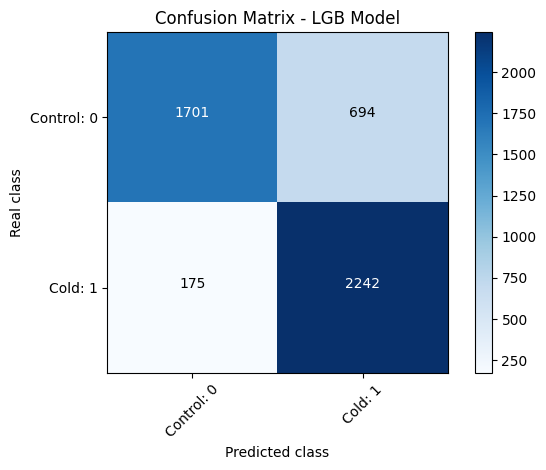

In [17]:
cnf_matrix = confusion_matrix(y_test, y_pred_lgb)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - LGB Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Cold: 1'])

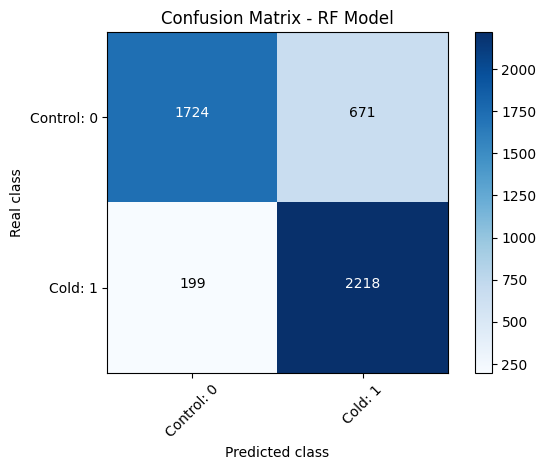

In [18]:
cnf_matrix = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix - RF Model',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Cold: 1'])

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = model_lgb.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.50    1.00      0.67 0.84      0.50
1        0.10       0.66    0.97      0.78 0.84      0.73
2        0.20       0.74    0.95      0.83 0.84      0.80
3        0.30       0.75    0.94      0.84 0.84      0.82
4        0.40       0.76    0.94      0.84 0.84      0.82
5        0.50       0.76    0.93      0.84 0.84      0.82
6        0.60       0.77    0.91      0.83 0.84      0.82
7        0.70       0.77    0.79      0.78 0.84      0.78
8        0.80       0.79    0.37      0.51 0.84      0.64
9        0.90       0.79    0.01      0.02 0.84      0.50
10       1.00       0.00    0.00      0.00 0.84      0.50


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = modelrf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision  Recall  F1 Score  AUC  Acurácia
0        0.00       0.50    1.00      0.67 0.84      0.50
1        0.10       0.61    0.98      0.75 0.84      0.68
2        0.20       0.71    0.96      0.82 0.84      0.78
3        0.30       0.75    0.94      0.84 0.84      0.81
4        0.40       0.76    0.94      0.84 0.84      0.82
5        0.50       0.77    0.92      0.84 0.84      0.82
6        0.60       0.77    0.86      0.81 0.84      0.80
7        0.70       0.78    0.67      0.72 0.84      0.74
8        0.80       0.79    0.34      0.47 0.84      0.62
9        0.90       0.81    0.06      0.11 0.84      0.52
10       1.00       0.00    0.00      0.00 0.84      0.50
